In [1]:
from ultralytics import YOLO
model = YOLO('yolo11n.pt')

In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import easyocr

In [3]:
# cek ketersedian CUDA untuk GPU

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())

CUDA available: True
CUDA device count: 1
Current device: 0


In [4]:
# Panggil model YOLO untuk mendeteksi kendaraan
vehicle_model = model  # Asumsikan model kendaraan sudah didefinisikan
plate_model = YOLO("license_plate_detector.pt")

# Deteksi kendaraan
def detect_vehicles(image_path):
    results = vehicle_model(image_path, device=1, classes=[2, 3, 5, 7])  # Deteksi kendaraan
    bb = []
    for r in results:
        boxes = r.boxes.xyxy.cuda()  # Bounding box format xyxy
        bb.append(boxes.cpu().numpy())
    return np.vstack(bb) if bb else np.array([])


In [5]:
# Deteksi plat nomor di dalam bounding box kendaraan
def detect_license_plates(image, vehicle_boxes):
    plate_boxes = []
    plate_texts = []
    reader = easyocr.Reader(["en"], gpu=True)  # Inisialisasi EasyOCR

    for box in vehicle_boxes:
        x1, y1, x2, y2 = map(int, box)
        cropped_vehicle = image[y1:y2, x1:x2]  # Potong bagian kendaraan
        cropped_vehicle_rgb = cv2.cvtColor(cropped_vehicle, cv2.COLOR_BGR2RGB)

        # Simpan sementara gambar kendaraan ke disk (YOLO membutuhkan file input)
        temp_path = 'temp_vehicle.jpg'
        cv2.imwrite(temp_path, cropped_vehicle_rgb)

        # Deteksi plat nomor
        plate_results = plate_model(temp_path, device=0)
        for r in plate_results:
            for p in r.boxes.xyxy.cpu().numpy():
                px1, py1, px2, py2 = map(int, p)
                plate_boxes.append([x1 + px1, y1 + py1, x1 + px2, y1 + py2])

                # Potong gambar plat nomor untuk OCR
                cropped_plate = cropped_vehicle[py1:py2, px1:px2]

                # Gabungkan peningkatan kualitas dan interpolasi
                enhanced_enlarged_plate = enhance_and_enlarge(cropped_plate,
                                                scale_factor=2,
                                                interpolation=cv2.INTER_CUBIC,
                                                enhancement_method="histogram_equalization")


                if cropped_plate.size > 0:
                    cropped_plate_gray = cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2GRAY)

                    # Gunakan EasyOCR untuk membaca teks
                    text = reader.readtext(cropped_plate_gray, detail=0)
                    plate_texts.append(" ".join(text))

    return np.array(plate_boxes), plate_texts

In [6]:
def enlarge_image(image, scale_factor=2):
    """Memperbesar gambar dengan faktor skala tertentu."""
    width = int(image.shape[1] * scale_factor)
    height = int(image.shape[0] * scale_factor)
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)
    return resized_image


def enhance_and_enlarge(image, scale_factor=2, interpolation=cv2.INTER_CUBIC, enhancement_method="histogram_equalization"):

    # 1. Image Interpolation
    width = int(image.shape[1] * scale_factor)
    height = int(image.shape[0] * scale_factor)
    enlarged_image = cv2.resize(image, (width, height), interpolation=interpolation)

    # 2. Image Enhancement
    enhanced_image = image_enhancement(enlarged_image, method=enhancement_method)

    return enhanced_image

def image_enhancement(image, method="histogram_equalization"):
    """Meningkatkan kualitas gambar menggunakan metode yang ditentukan."""
    if method == "histogram_equalization":
        # Histogram Equalization
        if len(image.shape) == 2:  # Grayscale image
            enhanced_image = cv2.equalizeHist(image)
        else:  # Color image
            img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
            enhanced_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    elif method == "unsharp_masking":
        # Unsharp Masking
        gaussian_blurred = cv2.GaussianBlur(image, (5, 5), 0)
        enhanced_image = cv2.addWeighted(image, 1.5, gaussian_blurred, -0.5, 0)
    else:
        # Default: return original image if method is invalid
        enhanced_image = image

    return enhanced_image


In [7]:
# Muat gambar sumber
image_path = "datasets/B2102PBH_AUS_310313032101_20240619153114231_X1036Y640W38H21_Motorcycle_Audi_unknown_031_02_08614.jpg"

image = cv2.imread(image_path)

# Deteksi kendaraan
vehicle_boxes = detect_vehicles(image_path)

# Deteksi plat nomor berdasarkan kendaraan
plate_boxes, plate_texts = detect_license_plates(image, vehicle_boxes)

# Konversi gambar ke RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Tambahkan bounding box kendaraan ke gambar
for box in vehicle_boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Warna merah untuk kendaraan

# Tambahkan bounding box plat nomor ke gambar
for i, box in enumerate(plate_boxes):
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Warna hijau untuk plat nomor
    if i < len(plate_texts):
        cv2.putText(image_rgb, plate_texts[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)



image 1/1 C:\Users\ASUS\Documents\Ngampus\Data-Mining\UAS\datasets\B2102PBH_AUS_310313032101_20240619153114231_X1036Y640W38H21_Motorcycle_Audi_unknown_031_02_08614.jpg: 384x640 1 car, 2 motorcycles, 1 bus, 1 truck, 61.0ms
Speed: 2.2ms preprocess, 61.0ms inference, 85.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\ASUS\Documents\Ngampus\Data-Mining\UAS\temp_vehicle.jpg: 640x640 1 license_plate, 13.9ms
Speed: 3.5ms preprocess, 13.9ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\ASUS\Documents\Ngampus\Data-Mining\UAS\temp_vehicle.jpg: 640x576 1 license_plate, 59.2ms
Speed: 2.0ms preprocess, 59.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 C:\Users\ASUS\Documents\Ngampus\Data-Mining\UAS\temp_vehicle.jpg: 640x416 1 license_plate, 44.6ms
Speed: 1.5ms preprocess, 44.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 C:\Users\ASUS\Documents\Ngampus\Data-Mining\UAS\te

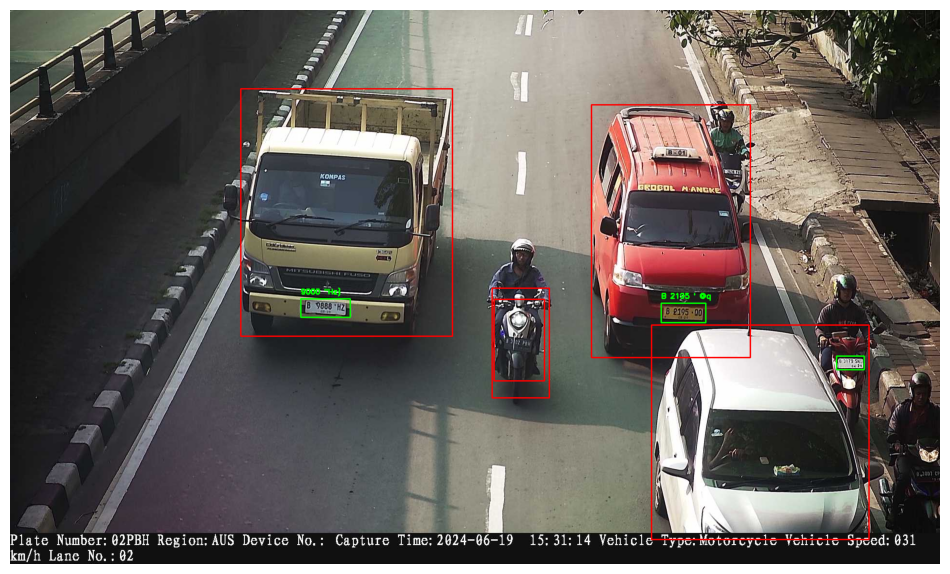

Gambar hasil disimpan di: output_image.jpg


In [8]:
# Tampilkan hasil
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()

# Simpan gambar hasil
output_path = "output_image.jpg"  # Tentukan path dan nama file untuk menyimpan gambar
cv2.imwrite(output_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))
print(f"Gambar hasil disimpan di: {output_path}")
